In [1]:
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# figure beautification
sns.set_theme(
    style='whitegrid',
    palette='deep',
    color_codes=True # access seaborn colors by changing matplotlib color shorthands
)
%config InlineBackend.figure_format = 'retina'

### Total volume change

All simulations ran for `nt = 25000` time steps, but while the scenarios used `dt = 2`, the reference still calculated on `dt = 1`.

In [2]:
# load ice thickness data

final_yr = 20000
h = {}
icevol = {}
scenarios = ['reference', 'glacial-climate', 'warm-climate']

for s in scenarios:
    data = np.load(f'{s}/simulation-data.npz')
    # load ice thickness for 10k years of simulation
    # & summarize to annual total ice volume in km^3
    
    # use if-statement to account for different time steps (!)
    if s == 'reference':
        icevol[s] = np.sum(data['h'][:final_yr:2], axis=(1,2)) * 40 * 40 / 1e3
    else:
        icevol[s] = np.sum(data['h'][:final_yr//2], axis=(1,2)) * 40 * 40 / 1e3
    # load ice thickness of final time step
    # here, equilibrium is reached anyways
    h[s] = data['h'][-1]

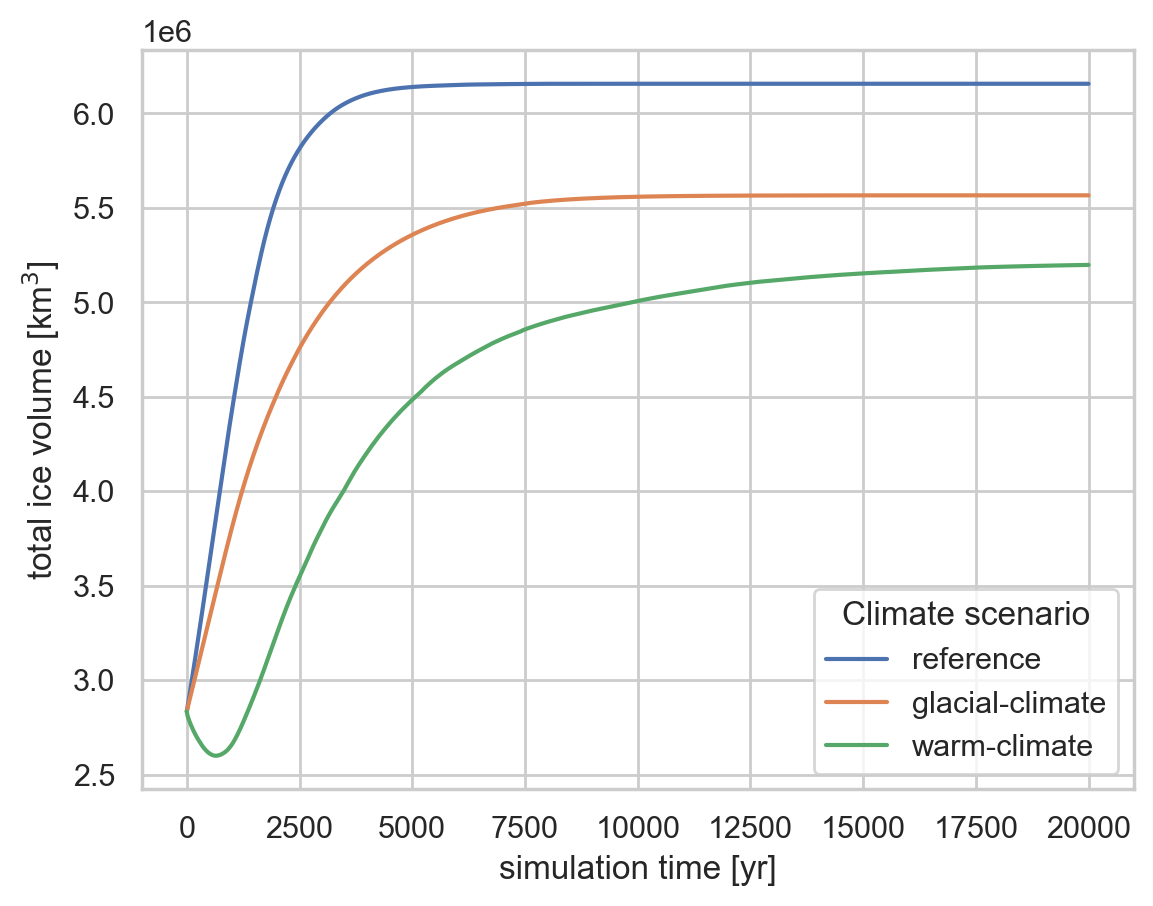

In [3]:
# explore total ice volume
x = np.arange(0, final_yr, 2)

fig, ax = plt.subplots()
for s in scenarios:
    ax.plot(x, icevol[s], label=s)

ax.set_xlabel('simulation time [yr]')
ax.set_ylabel('total ice volume [km$^3$]')
ax.legend(title='Climate scenario')

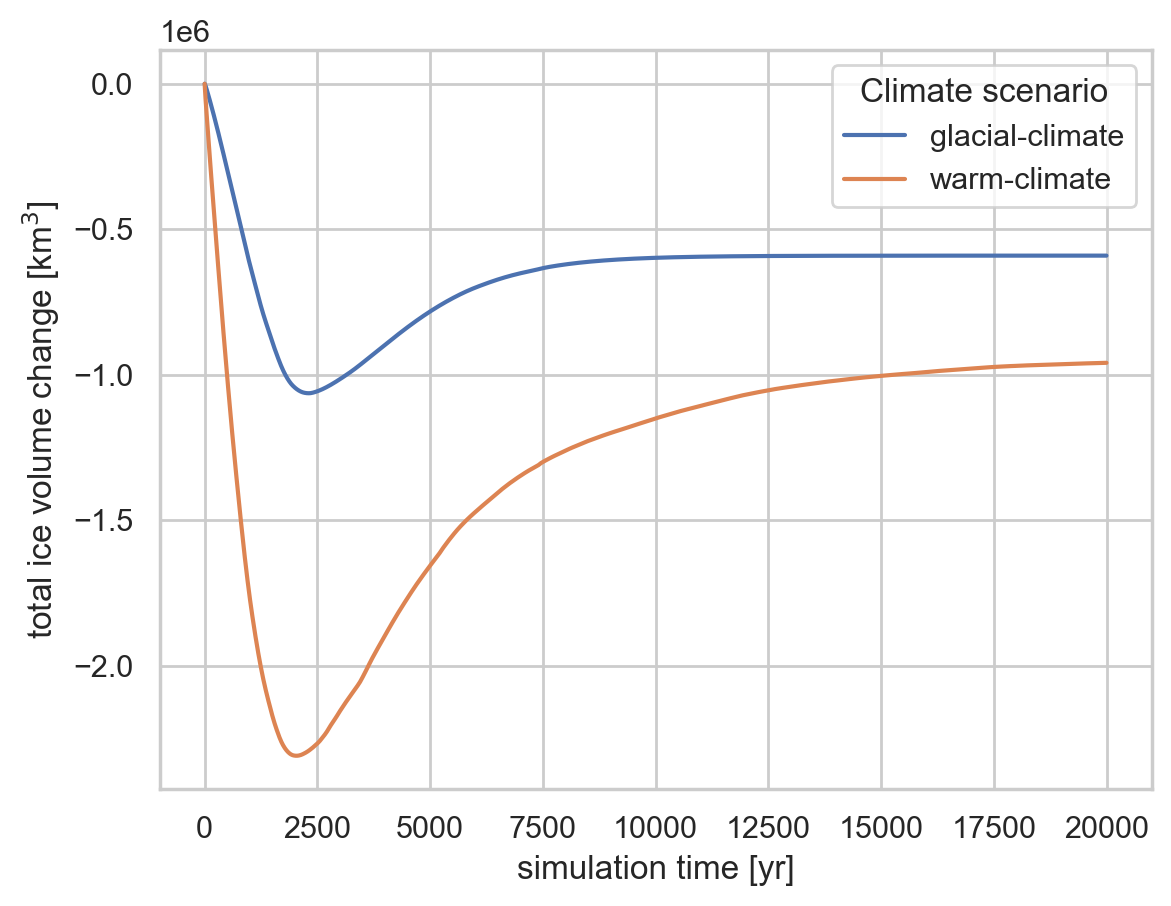

In [4]:
x = np.arange(0, final_yr, 2)

fig, ax = plt.subplots()
for s in ['glacial-climate', 'warm-climate']:
    ax.plot(x, icevol[s]-icevol['reference'], label=s)

ax.set_xlabel('simulation time [yr]')
ax.set_ylabel('total ice volume change [km$^3$]')
ax.legend(title='Climate scenario')
plt.savefig('figs/ice-volume-change.png', dpi=300, bbox_inches='tight')

### Ice thickness equilibrium maps

In [5]:
# find max ice thickness for color normalization
# & apply ocean mask
data = np.load('reference/simulation-data.npz')
seamask = data['seamask'][-1]
hmask = {}

for s in scenarios:
    hmax = np.max(h[s])
    # apply ocean mask to ice thickness
    hmask[s] = np.ma.masked_array(h[s], mask=seamask)
    print(f'{s}\t= {hmax} m')

reference	= 4486.542972020033 m
glacial-climate	= 4092.6916061210736 m
warm-climate	= 4709.764917071348 m


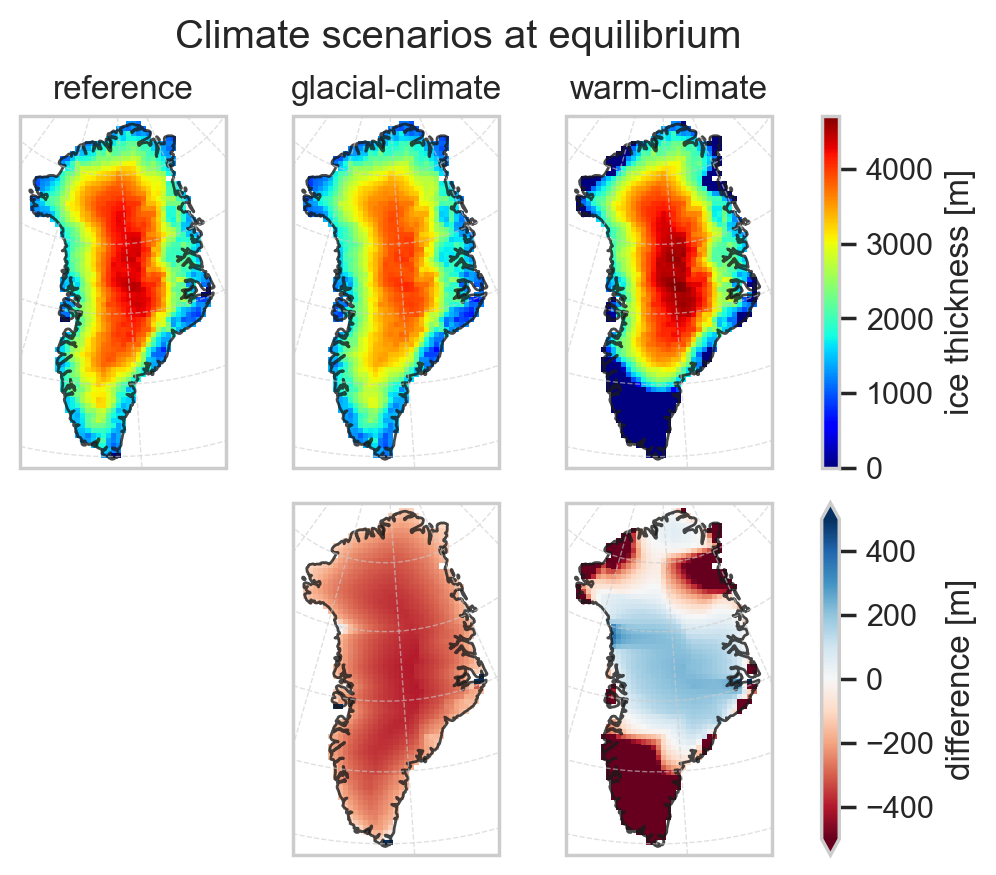

In [6]:
xlon    = data['xlon']
ylat    = data['ylat']
rows = 2
cols = 3

# plot greenland ice thickness map
trans = ccrs.PlateCarree()
proj = ccrs.NorthPolarStereo(central_longitude=-44)
fig, axs = plt.subplots(rows, cols, subplot_kw=dict(projection = proj),
                        gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
# add coastline of greenland
# get path to shapefile
shpfilename = shpreader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
# read shapefile
shpfile = shpreader.Reader(shpfilename)
# select greenland only
greenland = [country.geometry for country in shpfile.records() \
             if country.attributes["NAME_LONG"] == "Greenland"]



for col, s in zip(range(cols), scenarios):
    ax = axs[0, col]
    cm = ax.pcolormesh(xlon, ylat, hmask[s], cmap='jet',
                       shading='nearest', transform=trans,
                       norm=mpl.colors.Normalize(vmin=0, vmax=np.max(h['warm-climate'])))
    ax.set_title(s)
    # add greenland coastline
    ax.add_geometries(greenland, crs=trans, fc='none', ec='k', alpha=0.8)
    ax.gridlines(alpha=.6, ls='--', lw=.5)
cbar = fig.colorbar(cm, ax=axs[0, :])
cbar.set_label('ice thickness [m]')

for col, s in zip(range(cols), scenarios):
    ax = axs[1, col]
    cm = ax.pcolormesh(xlon, ylat, hmask[s]-hmask['reference'], cmap='RdBu',
                       shading='nearest', transform=trans,
                       norm=mpl.colors.CenteredNorm(halfrange=500))
    # add greenland coastline
    ax.add_geometries(greenland, crs=trans, fc='none', ec='k', alpha=0.8)
    ax.gridlines(alpha=.6, ls='--', lw=.5)
cbar = fig.colorbar(cm, ax=axs[1, :], extend='both')
cbar.set_label('difference [m]')
# remove redundant subplot
axs[1,0].set_visible(False)

fig.suptitle('Climate scenarios at equilibrium')
plt.savefig('figs/ice-thickness-maps.png', dpi=300, bbox_inches='tight')